In [4]:
import os
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
from urllib.request import urlopen
from PIL import Image
import timm
from torch import Tensor
from torchvision import transforms
from torch.utils.data import DataLoader,Dataset
from glob import glob
from sklearn.model_selection import train_test_split
import torch.nn as nn
import random
import torchmetrics
from torch.nn.modules.batchnorm import _BatchNorm
import matplotlib.pyplot as plt
import torch.nn.functional as F
device='cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class_list={
    'background':0,
    'Tumor':1,
    'Stroma':2,
    'Immune cells':3,
    'Necrosis':4,
    'alveoli':5,
    'Other':6
}
params={'image_size':128,
        'lr':2e-4,
        'beta1':0.5,
        'beta2':0.999,
        'batch_size':32,
        'epochs':200,
        'n_classes':len(class_list),
        'inch':3,
        }

In [6]:
trans = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])

def transback(data:Tensor) -> Tensor:
    return data / 2 + 0.5

class CustomDataset(Dataset):
    """COCO Custom Dataset compatible with torch.utils.data.DataLoader."""
    def __init__(self,parmas, images,label):
        
        self.images = images
        self.args=parmas
        self.label=label
        
    def trans(self,image):
        if random.random() > 0.5:
            transform = transforms.RandomHorizontalFlip(1)
            image = transform(image)
            
        if random.random() > 0.5:
            transform = transforms.RandomVerticalFlip(1)
            image = transform(image)
            
        return image
    
    def __getitem__(self, index):
        image=self.images[index]
        label=self.label[index]
        image = self.trans(image)
        return image,label
    
    def __len__(self):
        return len(self.images)


train_image_label=[]
train_image_path=[]
val_image_label=[]
val_image_path=[]
for dataset_name in range(2):
    for i in tqdm(range(len(class_list))):
        if dataset_name==0:
            image_list=glob(f'../../data/MIHIC/train/{list(class_list.keys())[i]}/*.png')
            train_image_path.extend(image_list)
            for k in range(len(image_list)):
                train_image_label.append(i)
        else:
            image_list=glob(f'../../data/MIHIC/val/{list(class_list.keys())[i]}/*.png')
            val_image_path.extend(image_list)
            for k in range(len(image_list)):
                val_image_label.append(i)

train_images=torch.zeros((len(train_image_path),params['inch'],params['image_size'],params['image_size']))
val_images=torch.zeros((len(val_image_path),params['inch'],params['image_size'],params['image_size']))

def replace_black_pixels(img_array):
    """검은색 픽셀 (0,0,0)을 흰색 (255,255,255)으로 변경"""
    # 모든 채널이 0인 픽셀 찾기
    black_mask = (img_array[:,:,0] == 0) & (img_array[:,:,1] == 0) & (img_array[:,:,2] == 0)
    # 검은색 픽셀을 흰색으로 변경
    img_array[black_mask] = [255, 255, 255]
    return img_array

for i in tqdm(range(len(train_image_path))):
    img = Image.open(train_image_path[i]).convert('RGB')
    img_array = np.array(img)
    img_array = replace_black_pixels(img_array)
    img = Image.fromarray(img_array)
    train_images[i]=trans(img)
    
for i in tqdm(range(len(val_image_path))):
    img = Image.open(val_image_path[i]).convert('RGB')
    img_array = np.array(img)
    img_array = replace_black_pixels(img_array)
    img = Image.fromarray(img_array)
    val_images[i]=trans(img)

train_dataset=CustomDataset(params,train_images,F.one_hot(torch.tensor(train_image_label)).to(torch.int64))
val_dataset=CustomDataset(params,val_images,F.one_hot(torch.tensor(val_image_label)).to(torch.int64))
dataloader=DataLoader(train_dataset,batch_size=params['batch_size'],shuffle=True)
val_dataloader=DataLoader(val_dataset,batch_size=params['batch_size'],shuffle=True)


100%|██████████| 7/7 [00:00<00:00, 96.64it/s]

100%|██████████| 49260/49260 [02:36<00:00, 314.37it/s]



In [7]:
class FeatureExtractor(nn.Module):
    """Feature extoractor block"""
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        cnn1= timm.create_model('tf_efficientnetv2_s', pretrained=True)
        self.feature_ex = nn.Sequential(*list(cnn1.children())[:-1])

    def forward(self, inputs):
        features = self.feature_ex(inputs)
        
        return features
class custom_model(nn.Module):
    def __init__(self, num_classes, image_feature_dim,feature_extractor_scale1: FeatureExtractor):
        super(custom_model, self).__init__()
        self.num_classes = num_classes
        self.image_feature_dim = image_feature_dim

        # Remove the classification head of the CNN model
        self.feature_extractor = feature_extractor_scale1
        # Classification layer
        self.classification_layer = nn.Linear(image_feature_dim, num_classes)
        
    def forward(self, inputs):
        batch_size, channels, height, width = inputs.size()
        
        # Feature extraction using the pre-trained CNN
        features = self.feature_extractor(inputs)  # Shape: (batch_size, 2048, 1, 1)
        
        # Classification layer
        logits = self.classification_layer(features)  # Shape: (batch_size, num_classes)
        
        return logits
    
class SAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, adaptive=False, **kwargs):
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"

        defaults = dict(rho=rho, adaptive=adaptive, **kwargs)
        super(SAM, self).__init__(params, defaults)

        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups
        self.defaults.update(self.base_optimizer.defaults)

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)

            for p in group["params"]:
                if p.grad is None: continue
                self.state[p]["old_p"] = p.data.clone()
                e_w = (torch.pow(p, 2) if group["adaptive"] else 1.0) * p.grad * scale.to(p)
                p.add_(e_w)  # climb to the local maximum "w + e(w)"

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None: continue
                p.data = self.state[p]["old_p"]  # get back to "w" from "w + e(w)"

        self.base_optimizer.step()  # do the actual "sharpness-aware" update

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def step(self, closure=None):
        assert closure is not None, "Sharpness Aware Minimization requires closure, but it was not provided"
        closure = torch.enable_grad()(closure)  # the closure should do a full forward-backward pass

        self.first_step(zero_grad=True)
        closure()
        self.second_step()

    def _grad_norm(self):
        shared_device = self.param_groups[0]["params"][0].device  # put everything on the same device, in case of model parallelism
        norm = torch.norm(
                    torch.stack([
                        ((torch.abs(p) if group["adaptive"] else 1.0) * p.grad).norm(p=2).to(shared_device)
                        for group in self.param_groups for p in group["params"]
                        if p.grad is not None
                    ]),
                    p=2
               )
        return norm

    def load_state_dict(self, state_dict):
        super().load_state_dict(state_dict)
        self.base_optimizer.param_groups = self.param_groups
        
def disable_running_stats(model):
    def _disable(module):
        if isinstance(module, _BatchNorm):
            module.backup_momentum = module.momentum
            module.momentum = 0

    model.apply(_disable)

def enable_running_stats(model):
    def _enable(module):
        if isinstance(module, _BatchNorm) and hasattr(module, "backup_momentum"):
            module.momentum = module.backup_momentum
            
import transformers

Feature_Extractor=FeatureExtractor()
model = custom_model(len(class_list),1280,Feature_Extractor)
model = model.to(device)
base_optimizer = torch.optim.SGD
# optimizer = SAM(model.parameters(), base_optimizer, lr=params['lr'], momentum=0.9)
optimizer=torch.optim.AdamW(model.parameters(), lr=params['lr'], betas=(params['beta1'], params['beta2']))
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=len(class_list)).to(device)

epoch: 1/50 Step: 6095 loss : 1.3566 accuracy: 0.8079: 100%|██████████| 6094/6094 [05:56<00:00, 17.10it/s]
epoch: 1/50 Step: 6095 loss : 1.3566 accuracy: 0.8079: 100%|██████████| 6094/6094 [05:56<00:00, 17.10it/s]
Validation epoch: 1/50 Step: 1541 loss : 1.3191  accuracy: 0.8451: 100%|██████████| 1540/1540 [00:32<00:00, 47.67it/s]

epoch: 2/50 Step: 6095 loss : 1.3194 accuracy: 0.8450: 100%|██████████| 6094/6094 [05:56<00:00, 17.09it/s]
epoch: 2/50 Step: 6095 loss : 1.3194 accuracy: 0.8450: 100%|██████████| 6094/6094 [05:56<00:00, 17.09it/s]
Validation epoch: 2/50 Step: 1541 loss : 1.3101  accuracy: 0.8538: 100%|██████████| 1540/1540 [00:32<00:00, 47.47it/s]

epoch: 3/50 Step: 6095 loss : 1.3024 accuracy: 0.8619: 100%|██████████| 6094/6094 [05:58<00:00, 17.02it/s]
epoch: 3/50 Step: 6095 loss : 1.3024 accuracy: 0.8619: 100%|██████████| 6094/6094 [05:58<00:00, 17.02it/s]
Validation epoch: 3/50 Step: 1541 loss : 1.3083  accuracy: 0.8556: 100%|██████████| 1540/1540 [00:32<00:00, 47.56it/s]

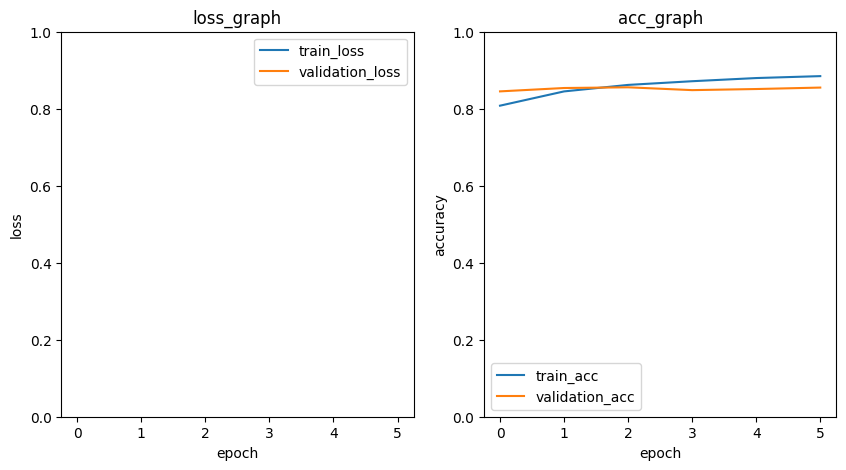

epoch: 7/50 Step: 6095 loss : 1.2750 accuracy: 0.8897: 100%|██████████| 6094/6094 [05:59<00:00, 16.94it/s]
epoch: 7/50 Step: 6095 loss : 1.2750 accuracy: 0.8897: 100%|██████████| 6094/6094 [05:59<00:00, 16.94it/s]
Validation epoch: 7/50 Step: 1541 loss : 1.3070  accuracy: 0.8573: 100%|██████████| 1540/1540 [00:32<00:00, 47.93it/s]
Validation epoch: 7/50 Step: 1541 loss : 1.3070  accuracy: 0.8573: 100%|██████████| 1540/1540 [00:32<00:00, 47.93it/s]
epoch: 8/50 Step: 6095 loss : 1.2703 accuracy: 0.8944: 100%|██████████| 6094/6094 [05:56<00:00, 17.07it/s]
epoch: 8/50 Step: 6095 loss : 1.2703 accuracy: 0.8944: 100%|██████████| 6094/6094 [05:56<00:00, 17.07it/s]
Validation epoch: 8/50 Step: 1541 loss : 1.3061  accuracy: 0.8580: 100%|██████████| 1540/1540 [00:32<00:00, 47.53it/s]
Validation epoch: 8/50 Step: 1541 loss : 1.3061  accuracy: 0.8580: 100%|██████████| 1540/1540 [00:32<00:00, 47.53it/s]
epoch: 9/50 Step: 6095 loss : 1.2663 accuracy: 0.8987: 100%|██████████| 6094/6094 [05:57<00:00, 

KeyboardInterrupt: 

In [8]:
MIN_loss=5000
train_loss_list=[]
val_loss_list=[]
train_acc_list=[]
sig=nn.Sigmoid()
val_acc_list=[]

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
create_dir('../../results/IHC_Tissue_Region_classification/')
for epoch in range(1000):
    train=tqdm(dataloader)
    count=0
    running_loss = 0.0
    acc_loss=0
    model.train()
    for x, y in train:
        
        y = y.to(device).float()
        count+=1
        x=x.to(device).float()
        optimizer.zero_grad()  # optimizer zero 로 초기화
        predict = model(x).to(device)
        cost = F.cross_entropy(predict.softmax(dim=1), y) # cost 구함
        acc=accuracy(predict.softmax(dim=1).argmax(dim=1),y.argmax(dim=1))
        cost.backward() # cost에 대한 backward 구함
        optimizer.step()
        running_loss += cost.item()
        acc_loss+=acc
        train.set_description(f"epoch: {epoch+1}/{50} Step: {count+1} loss : {running_loss/count:.4f} accuracy: {acc_loss/count:.4f}")
    train_loss_list.append((running_loss/count))
    train_acc_list.append((acc_loss/count).cpu().detach().numpy())
#validation
    val=tqdm(val_dataloader)
    model.eval()
    count=0
    val_running_loss=0.0
    acc_loss=0
    with torch.no_grad():
        for x, y in val:
            y = y.to(device).float()
            count+=1
            x=x.to(device).float()
            predict = model(x).to(device)
            cost = F.cross_entropy(predict.softmax(dim=1), y) # cost 구함
            acc=accuracy(predict.softmax(dim=1).argmax(dim=1),y.argmax(dim=1))
            val_running_loss+=cost.item()
            acc_loss+=acc
            val.set_description(f"Validation epoch: {epoch+1}/{50} Step: {count+1} loss : {val_running_loss/count:.4f}  accuracy: {acc_loss/count:.4f}")
        val_loss_list.append((val_running_loss/count))
        val_acc_list.append((acc_loss/count).cpu().detach().numpy())
    if epoch%100==5:
        plt.figure(figsize=(10,5))
        plt.subplot(1, 2, 1) 
        plt.title('loss_graph')
        plt.plot(np.arange(epoch+1),train_loss_list,label='train_loss')
        plt.plot(np.arange(epoch+1),val_loss_list,label='validation_loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.ylim([0, 1]) 
        plt.legend()
        plt.subplot(1, 2, 2)  
        plt.title('acc_graph')
        plt.plot(np.arange(epoch+1),train_acc_list,label='train_acc')
        plt.plot(np.arange(epoch+1),val_acc_list,label='validation_acc')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.ylim([0, 1]) 
        plt.legend()
        plt.savefig(f'../../results/IHC_Tissue_Region_classification/epoch{epoch}.png')
        plt.show()
        
        
    if MIN_loss>(val_running_loss/count):
        create_dir('../../model/IHC_Tissue_Region_classification/')
        torch.save(model.state_dict(), '../../model/IHC_Tissue_Region_classification/check.pt')
        MIN_loss=(val_running_loss/count)
torch.save(model.state_dict(), '../../model/IHC_Tissue_Region_classification/last.pt')